In this notebook, we cover multi-output GPs. The presentation follows the [excellent video from GPSS](https://www.youtube.com/watch?v=ttgUJtVJthA)

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
#matplotlib.rcParams['figure.figsize'] = (8,6)
from matplotlib import pyplot as plt
import GPy

# ICM 

$u \sim GP (0, k)$

sample from u to get a sample $u^1$

$f_1(x) = a^1_1 u^1(x)$

$f_2(x) = a^1_2 u^1(x)$

In [2]:
X = np.linspace(-3.,3., 50)

In [3]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=2.)

In [4]:
kernel

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,2.0,+ve,


In [5]:
def jitter(C,  j = 1e-6):
    return C + np.eye(len(C))*j

In [6]:
cov = jitter(kernel.K(X.reshape(-1, 1)))

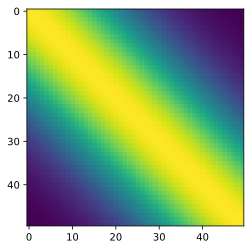

In [7]:
plt.imshow(cov)

In [8]:
mvn = multivariate_normal(cov=cov)

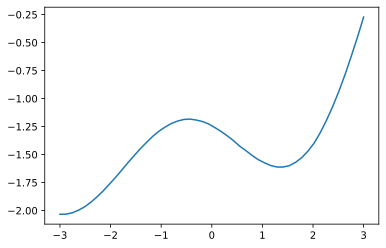

In [9]:
u1 = mvn.rvs(random_state=0)
plt.plot(X, u1)

In [10]:
a11 = 0.9
a12 = 0.7

a = np.array([a11, a12]).reshape(-1, 1)

In [11]:
a

array([[0.9],
       [0.7]])

In [12]:
B = a@a.T
B

array([[0.81, 0.63],
       [0.63, 0.49]])

In [13]:
cov_f = np.kron(B, cov)

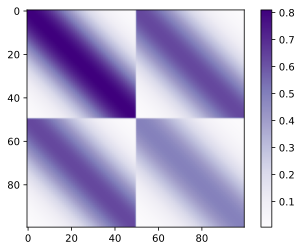

In [14]:
plt.imshow(cov_f, cmap='Purples')
plt.colorbar()

In [15]:
f_sample = multivariate_normal(cov=jitter(cov_f)).rvs(size=500)
f1_samples, f2_samples = f_sample[:, :50], f_sample[:, 50:]

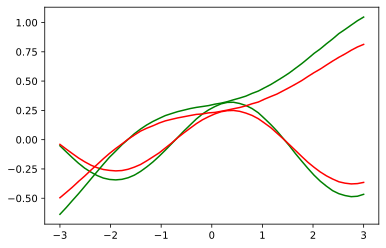

In [16]:
#plt.plot(X, u1, label="u1")
for i in range(2):
    plt.plot(X, f1_samples[i], color='g') 
    plt.plot(X, f2_samples[i], color='r' )


In [17]:
f1_samples[i]/f2_samples[i]

array([1.28521323, 1.2870487 , 1.28169798, 1.29387391, 1.28381124,
       1.29063798, 1.28399272, 1.28787108, 1.27634933, 1.29367057,
       1.19405718, 0.81421541, 1.29366628, 1.23932848, 1.28601429,
       1.31178054, 1.27596873, 1.28139033, 1.28548127, 1.28874727,
       1.288544  , 1.28851575, 1.27706874, 1.28929381, 1.27167387,
       1.30216154, 1.28769528, 1.28397652, 1.2896767 , 1.29357874,
       1.28743778, 1.28867757, 1.29135504, 1.28085954, 1.27832016,
       1.29113682, 1.28346876, 1.28115477, 1.28579679, 1.28664088,
       1.2836771 , 1.28690568, 1.28521466, 1.28474094, 1.28147929,
       1.28752966, 1.28577663, 1.28154063, 1.28312776, 1.2869964 ])

In [18]:
## Learning in MOGP setting

f1_dataset = f1_samples[4]
f2_dataset  = f2_samples[4]

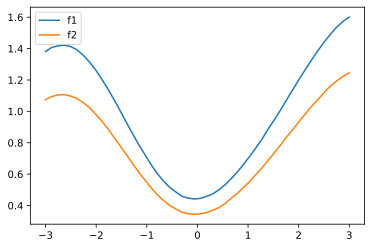

In [19]:
plt.plot(X, f1_dataset, label='f1')
plt.plot(X, f2_dataset, label='f2')
plt.legend()

In [20]:
## What all we want to learn:

# 1. GP kernel parameters
# 2. a11, a12

In [21]:
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import tensorflow_probability.substrates.jax as tfp

In [22]:
f = jnp.hstack([f1_dataset, f2_dataset])

In [23]:
def sqexp(a, b, var=1.0, ls=4):
    diff = (a-b)/ls
    d = jnp.sum(diff ** 2)
    return var*jnp.exp(-0.5 * d)

def all_pairs(f):
    f = jax.vmap(f, in_axes= (None, 0, None, None))
    f = jax. vmap (f, in_axes= (0, None, None, None))
    return f

In [24]:
kernel.K(X.reshape(-1, 1))

array([[1.        , 0.99812754, 0.99253116, ..., 0.01592046, 0.01332383,
        0.011109  ],
       [0.99812754, 1.        , 0.99812754, ..., 0.01895197, 0.01592046,
        0.01332383],
       [0.99253116, 0.99812754, 1.        , ..., 0.02247631, 0.01895197,
        0.01592046],
       ...,
       [0.01592046, 0.01895197, 0.02247631, ..., 1.        , 0.99812754,
        0.99253116],
       [0.01332383, 0.01592046, 0.01895197, ..., 0.99812754, 1.        ,
        0.99812754],
       [0.011109  , 0.01332383, 0.01592046, ..., 0.99253116, 0.99812754,
        1.        ]])

In [25]:
np.allclose(np.array(all_pairs(sqexp)(X, X, 1.0, 2.0)), kernel.K(X.reshape(-1, 1)))

True

In [27]:
rank = 1
output_dim = 2
A = jax.random.normal(key=jax.random.PRNGKey(0), shape=(output_dim,rank))/10.0
A@A.T, A

(DeviceArray([[ 0.03298171, -0.01370936],
              [-0.01370936,  0.00569851]], dtype=float64),
 DeviceArray([[ 0.18160867],
              [-0.07548848]], dtype=float64))

In [28]:
output_dim = 2
rank = 4
A = jax.random.normal(key=jax.random.PRNGKey(0), shape=(output_dim,rank))/2.0
A@A.T

DeviceArray([[ 1.24957827, -0.04698574],
             [-0.04698574,  0.57577417]], dtype=float64)

In [29]:
def covariance_f(var, ls, A):
    """
    A: (output_dim, rank)    
    A can be generated as:
    A = jax.random.normal(key=jax.random.PRNGKey(0), shape=(output_dim,rank))
    """
    B = A@A.T
    cov = all_pairs(sqexp)(X, X, var, ls)
    cov_f = jitter(jnp.kron(B, cov))
    return cov_f

In [30]:
def cost(var, ls, A):
    cov_f = covariance_f(var, ls, A)
    dist = tfp.distributions.MultivariateNormalFullCovariance(loc = jnp.zeros_like(f), covariance_matrix = cov_f)
    return -dist.log_prob(f)

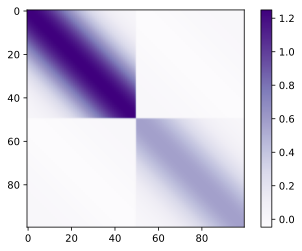

In [31]:
plt.imshow(covariance_f(1.0, 2.0, A), cmap='Purples')
plt.colorbar()

In [32]:
cost(1.0, 2.0, A)

DeviceArray(-431.60947116, dtype=float64)

In [33]:
cost(1.0, 1.0, A)

DeviceArray(-387.35267033, dtype=float64)

In [34]:
grads = jax.grad(cost, argnums=[0, 1, 2])(0.1, 1.0, A)

var = 0.1
ls = 1.0

lr = 1e-3

In [35]:
for i in range(500):
    grads = jax.grad(cost, argnums=[0, 1, 2])(var, ls, A)
    var = var-lr*grads[0]
    ls = ls-lr*grads[1]
    A = A-lr*grads[2]
    if i%100==0:
        print(i, cost(1.0, 1.0, A), var, ls)

0 -387.06097276826193 0.500429427376359 1.0913929924306696
100 -306.72979544101435 3.6414838350262055 2.363476650308803
200 -305.64842462218047 3.514293617054404 2.3873529546968477
300 -304.7976816183849 3.379382170959892 2.403204858135416
400 -304.0941499412901 3.236859846397818 2.4140771572105426


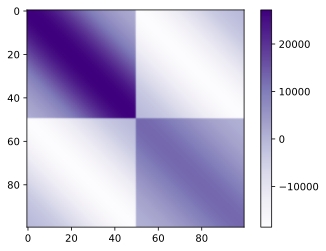

In [36]:
C_learnt = covariance_f(var, ls, A)
plt.imshow(C_learnt, cmap='Purples')
plt.colorbar()

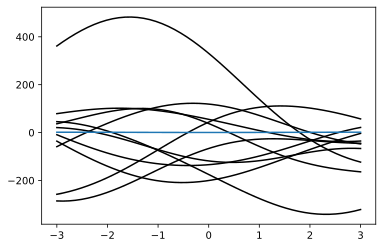

In [37]:
dist = tfp.distributions.MultivariateNormalFullCovariance(covariance_matrix=C_learnt)
samples_f1 = dist.sample(sample_shape=(10, ), seed = jax.random.PRNGKey(0))
for s in samples_f1:
    plt.plot(X, s[:50], color='k')
plt.plot(X, f1_dataset)


# SLFM

In [38]:
def covariance_f_SLFM(var1, ls1, A1, var2, ls2, A2):
    """

    """
    B1 = A1@A1.T
    B2 = A2@A2.T
    cov1 = all_pairs(sqexp)(X, X, var1, ls1)
    cov2 = all_pairs(sqexp)(X, X, var1, ls1)
    cov_f = jitter(jnp.kron(B1, cov1) + jnp.kron(B2, cov2))
    return cov_f

In [39]:
rank = 1
a1 = jax.random.normal(key=jax.random.PRNGKey(0), shape=(output_dim,rank))/2.0
a2 = jax.random.normal(key=jax.random.PRNGKey(0), shape=(output_dim,rank))/2.0



In [40]:
C_SLFM = covariance_f_SLFM(1.0, 2.0, a1@a1.T, 1.0, 4.0, a2@a2.T)

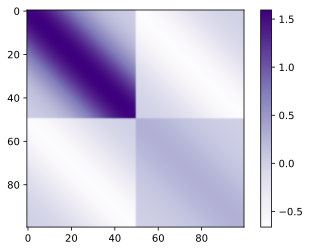

In [41]:
plt.imshow(C_SLFM, cmap='Purples')
plt.colorbar()